In [16]:
import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import scipy.io

import scipy.sparse as sps
import matplotlib.pyplot as plt

from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

from scNCL.metrics import osr_evaluator
from scNCL.core import BuildscNCL
import scNCL.utils as utls

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(1234)

sc.settings.verbosity = 3
sc.logging.print_header()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.7.2 anndata==0.7.8 umap==0.5.1 numpy==1.18.2 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.11.1 python-igraph==0.9.4 louvain==0.7.0


## experiment id

In [2]:
exp_id = 'MCA-subset' + '-1301'  # dataset_name + timestamp

## loading data

In [31]:
data_root = '../data/MCA/scjoint/data_subset'

adata_atac = sc.read_h5ad(join(data_root, 'adata_atac_cache.h5ad'))
adata_rna = sc.read_h5ad(join(data_root, 'adata_rna_facs.h5ad'))
adata_rna.obs['domain'] = 'rna'
adata_atac.obs['domain'] = 'atac'

meta_rna = adata_rna.obs.copy()
meta_atac = adata_atac.obs.copy()

meta = pd.concat([meta_rna, meta_atac], axis=0)

In [4]:
adata_rna, adata_atac

(AnnData object with n_obs × n_vars = 19726 × 15519
     obs: 'cell_type', 'domain',
 AnnData object with n_obs × n_vars = 57563 × 15519
     obs: 'cell_type', 'domain')

In [6]:
# low-dimension representations of raw scATAC-seq data
atac_raw_emb = np.load('../cache/MCAsubset_atac_tsne.npy')
atac_raw_emb.shape

(57563, 2)

In [7]:
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':adata_atac.shape[1], 
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':False
       }  # default settings

#  outputs folder
output_dir = join(f'../outputs/{exp_id}')
os.makedirs(output_dir, exist_ok=True)

## model 

In [9]:
model = BuildscNCL(
                'non_linear', n_latent=64, bn=False, dr=0.2, 
                cont_w=0.05, cont_tau=0.4,
        )
    
model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=None, 
                pp_dict = ppd
        )
    
if 1:
    model.train(
        opt='adam', 
        batch_size=500, training_steps=1000, 
        lr=0.001, weight_decay=5e-4,
        log_step=50, eval_atac=False, #eval_top_k=1, eval_open=True,  
    )
else:
    # loading checkpoints
    ckpt_path = join(output_dir, 'ckpt_1000.pth')
    model.load_ckpt(ckpt_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


knn correct ratio = 0.9931
step 0, loss_cls=2.971, loss_l1_reg=0.025, center=(0.005, 0.005), corr=(0.000, 0.000), var=(2.219, 2.404), loss_cont=0.345, loss_align=0.000
step 50, loss_cls=0.546, loss_l1_reg=0.024, center=(0.113, 0.071), corr=(0.029, 0.013), var=(0.074, 0.114), loss_cont=0.336, loss_align=0.000
step 100, loss_cls=0.297, loss_l1_reg=0.022, center=(0.104, 0.063), corr=(0.031, 0.013), var=(0.074, 0.118), loss_cont=0.326, loss_align=0.000
step 150, loss_cls=0.204, loss_l1_reg=0.021, center=(0.096, 0.060), corr=(0.027, 0.014), var=(0.078, 0.117), loss_cont=0.316, loss_align=0.000
step 200, loss_cls=0.173, loss_l1_reg=0.019, center=(0.084, 0.061), corr=(0.022, 0.016), var=(0.087, 0.112), loss_cont=0.309, loss_align=0.000
step 250, loss_cls=0.127, loss_l1_reg=0.018, center=(0.080, 0.058), corr=(0.021, 0.015), var=(0.090, 0.116), loss_cont=0.303, loss_align=0.000
step 300, loss_cls=0.093, loss_l1_reg=0.018, center=(0.073, 0.059), corr=(0.018, 0.017), var=(0.098, 0.112), loss_cont

In [10]:
model.eval(inplace=True)
atac_pred_type = model.annotate()

In [11]:
ad_atac = sc.AnnData(model.feat_B)
ad_atac.obs = meta_atac.copy()
ad_atac.obs['pred_type'] = atac_pred_type
ad_atac.obs['pred_conf'] = np.max(model.head_B, axis=1)

In [13]:
ad_atac = utls.umap_for_adata(ad_atac)

... storing 'domain' as categorical
... storing 'pred_type' as categorical


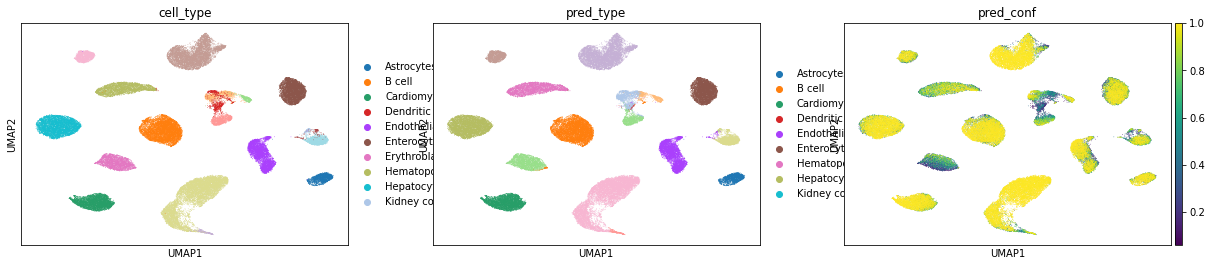

In [14]:
sc.pl.umap(ad_atac, color=['cell_type', 'pred_type', 'pred_conf'])

# Evaluation

In [12]:
share_mask = meta_atac.cell_type.isin(meta_rna.cell_type.unique()).to_numpy()
open_score = 1 - np.max(model.head_B, axis=1) # pb_max, logit_max_B

kn_data_pr = atac_pred_type[share_mask]
kn_data_gt = meta_atac.cell_type[share_mask].to_numpy()
kn_data_open_score = open_score[share_mask]

unk_data_open_score = open_score[np.logical_not(share_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)

close_acc= 0.8964


<AxesSubplot:>

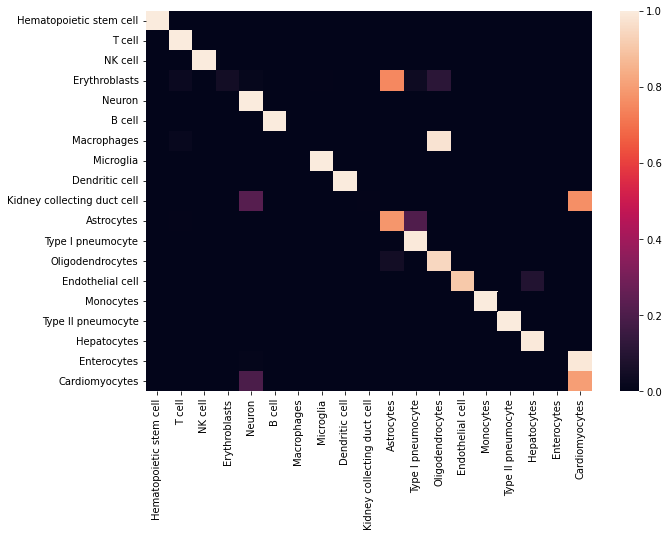

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(meta_atac.cell_type.to_numpy(), atac_pred_type)
cm = cm/cm.sum(axis=1, keepdims=True)

df_cm = pd.DataFrame(cm, index = meta_atac.cell_type.unique(),
                  columns = meta_atac.cell_type.unique())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, )